In [1]:
import h5py
import numpy as np
import tensorflow as tf

from augmentations import rotate_point_cloud, \
    translate_point_cloud, insert_outliers_to_point_cloud, jitter_point_cloud
from network import build_classification_network


def get_data(files):

    X = []
    y = []

    for file in files:

        f = h5py.File(file)

        data, label = f["data"][:], f["label"][:]

        X.append(data)
        y.append(label)

    X = np.concatenate(X, axis=0)
    y_ = np.concatenate(y, axis=0)[:, 0]

    y = np.zeros((len(y_), 40))
    y[np.arange(len(y)), y_] = 1

    return X, y


def augment(X, rotate=False, translate=False, insert_outliers=False, jitter=False):

    if rotate:
        X = rotate_point_cloud(X)

    if translate:
        X = translate_point_cloud(X)

    if insert_outliers:
        X = insert_outliers_to_point_cloud(X)

    if jitter:
        X = jitter_point_cloud(X)

    return X


def data_generator(X, y, batch_size=32, nb_points=1024, **kwargs):

    nb_batches = X.shape[0] // batch_size
    max_points = X.shape[1]
    assert max_points >= nb_points

    while True:

        np.random.shuffle(X)
        np.random.shuffle(y)

        for i in range(nb_batches):

            start = i * batch_size
            end = (i + 1) * batch_size

            yield augment(X[start:end, sorted(np.random.choice(max_points, size=nb_points, replace=False))], **kwargs), y[start:end]


def r_train():

    training_data = [
        "/home/francesco/data/modelnet40_ply_hdf5_2048/ply_data_train0.h5",
        "/home/francesco/data/modelnet40_ply_hdf5_2048/ply_data_train1.h5",
        "/home/francesco/data/modelnet40_ply_hdf5_2048/ply_data_train2.h5",
        "/home/francesco/data/modelnet40_ply_hdf5_2048/ply_data_train3.h5",
        "/home/francesco/data/modelnet40_ply_hdf5_2048/ply_data_train4.h5",
    ]

    testing_data = [
        "/home/francesco/data/modelnet40_ply_hdf5_2048/ply_data_test0.h5",
        "/home/francesco/data/modelnet40_ply_hdf5_2048/ply_data_test1.h5"
    ]

    NB_POINTS = 1024
    BATCH_SIZE = 32

    model = build_classification_network(BATCH_SIZE, NB_POINTS, (8, 8, 8), 0.0156)

    optimizer = tf.keras.optimizers.Adam(lr=0.0005, clipnorm=2.0)

    model.compile(optimizer=optimizer,
                  loss="categorical_crossentropy",
                  metrics=["categorical_accuracy"])

    print(model.summary())

    X_train, y_train = get_data(training_data)
    X_val, y_val = get_data(testing_data)

    train_gen = data_generator(X_train, y_train, batch_size=BATCH_SIZE, nb_points=NB_POINTS,
                               translate=True, insert_outliers=True, jitter=True, rotate=True)

    valid_gen = data_generator(X_val, y_val, batch_size=BATCH_SIZE, nb_points=NB_POINTS,
                               translate=False, insert_outliers=False, jitter=False, rotate=False)
    
    return model, train_gen, valid_gen

/home/francesco/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
model, train_gen, valid_gen = r_train()

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updatin

In [3]:
fv = tf.keras.Model(inputs=model.input, outputs=model.get_layer("modified3d_fisher_vectors").output)
fv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
points (InputLayer)          (32, 1024, 3)             0         
_________________________________________________________________
modified3d_fisher_vectors (M (32, 20, 512)             0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [4]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
points (InputLayer)             (32, 1024, 3)        0                                            
__________________________________________________________________________________________________
modified3d_fisher_vectors (Modi (32, 20, 512)        0           points[0][0]                     
__________________________________________________________________________________________________
reshape_3dmFV (Reshape)         (32, 20, 8, 8, 8)    0           modified3d_fisher_vectors[0][0]  
__________________________________________________________________________________________________
permute_3dmFV (Permute)         (32, 8, 8, 8, 20)    0           reshape_3dmFV[0][0]              
__________________________________________________________________________________________________
block1_1x1

In [5]:
points, label = next(train_gen)

/home/francesco/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


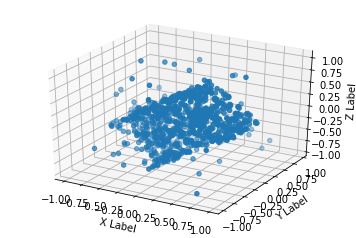

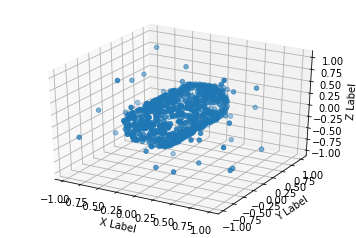

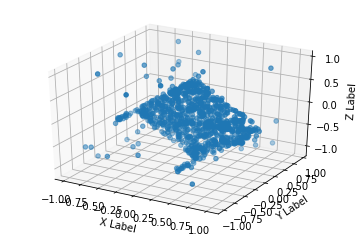

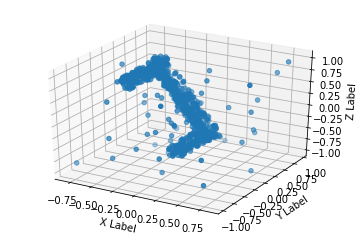

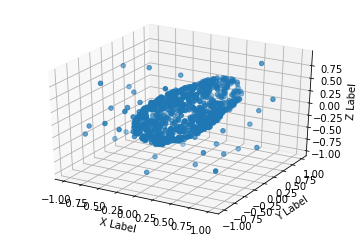

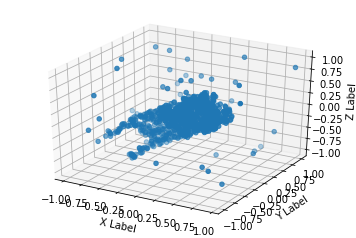

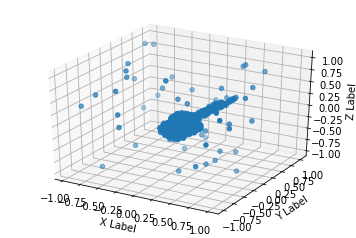

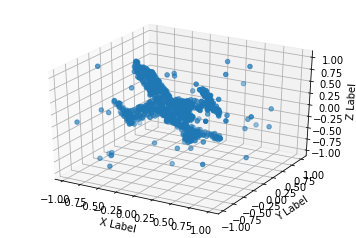

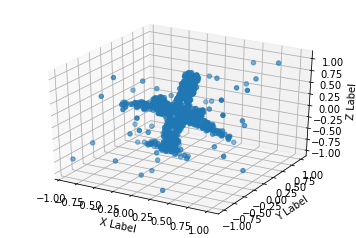

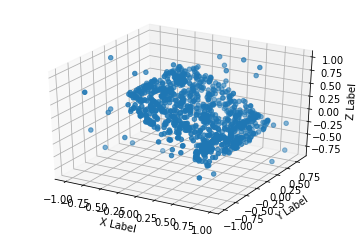

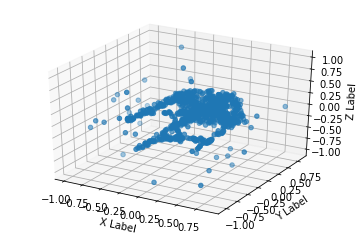

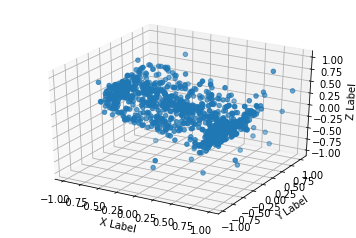

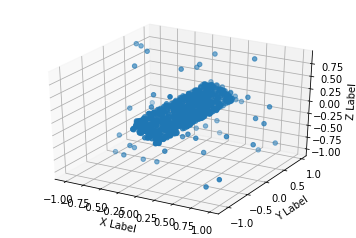

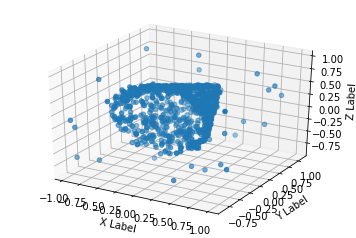

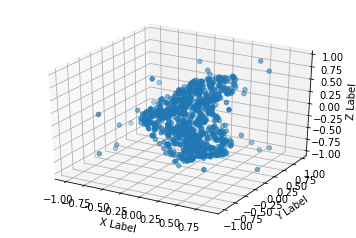

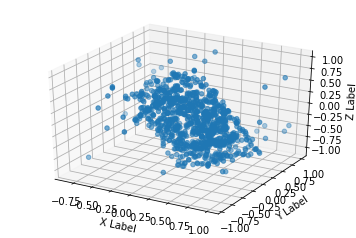

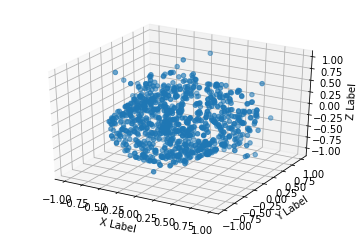

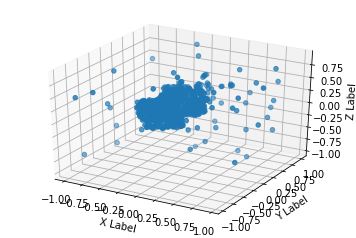

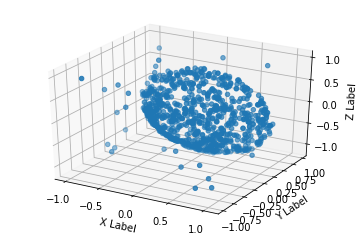

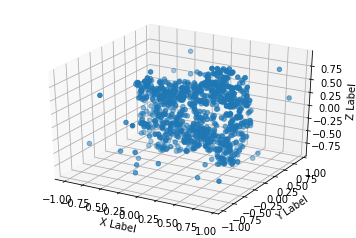

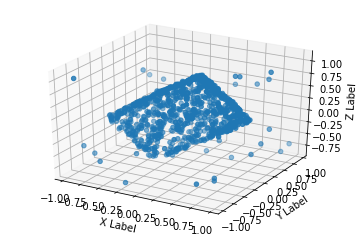

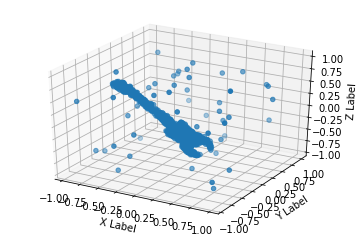

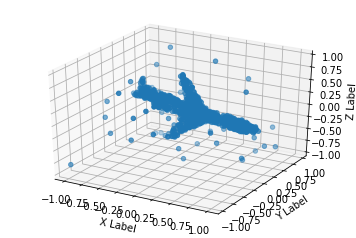

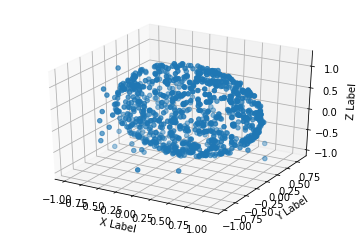

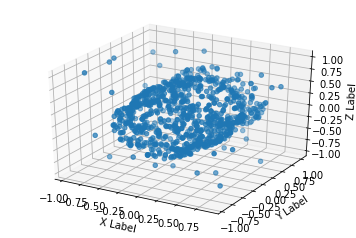

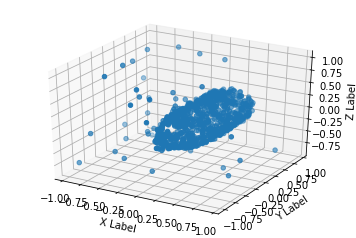

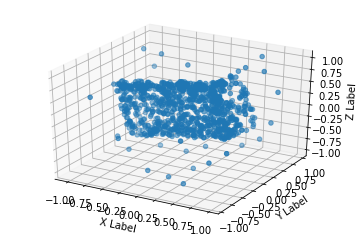

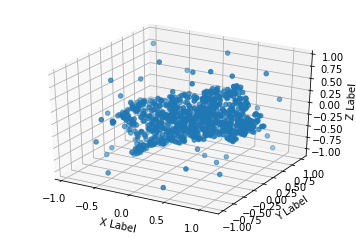

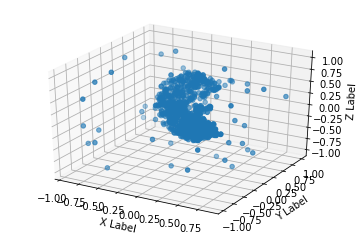

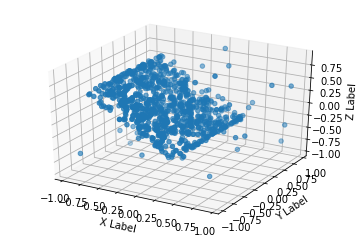

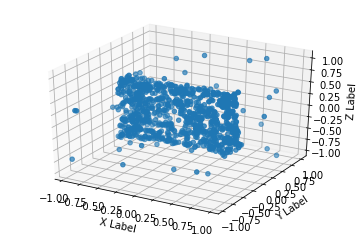

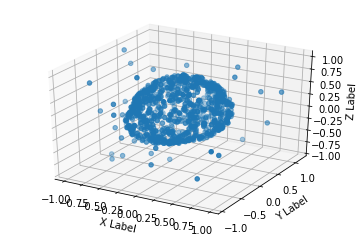

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

for pts in points:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pts[:,0], pts[:,1], pts[:,2])
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

In [7]:
label.argmax(axis=-1)

array([22,  6, 10,  5, 30, 38, 14,  7, 18, 37,  8, 13, 23, 37, 37,  0, 15,
       39, 14, 34, 25, 19, 22,  5,  5,  0, 35, 21, 18, 37, 15, 37])

In [8]:
feature_maps = fv.predict_on_batch(points)

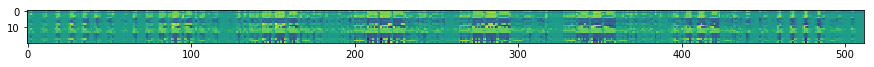

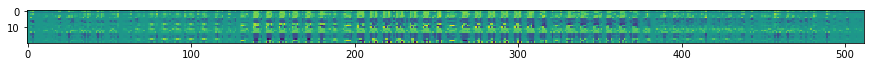

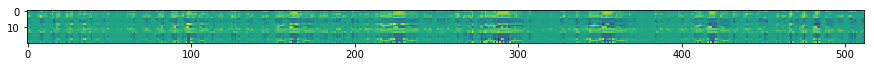

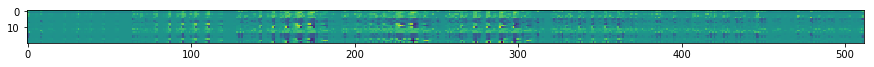

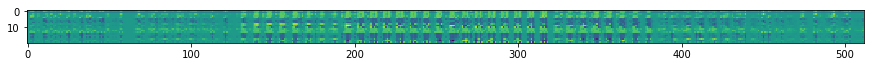

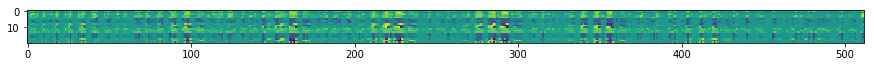

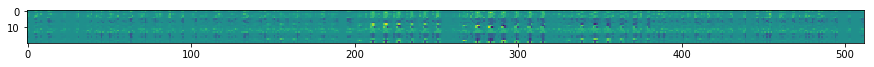

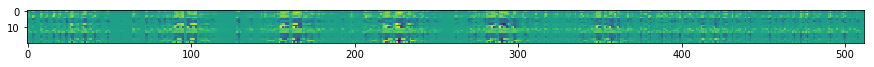

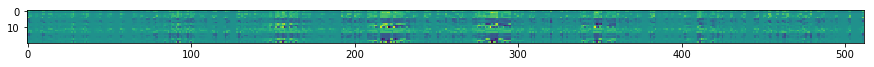

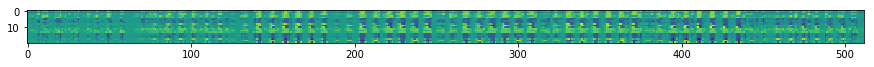

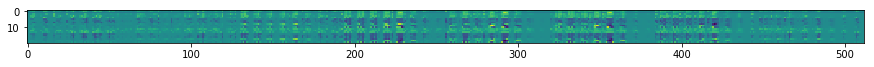

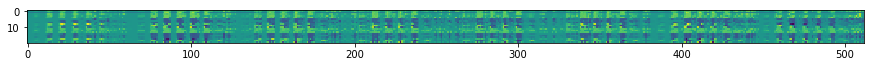

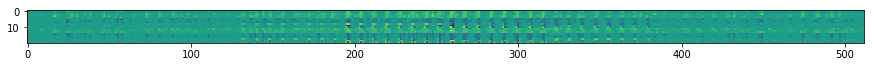

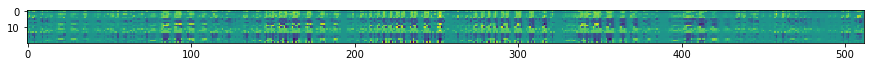

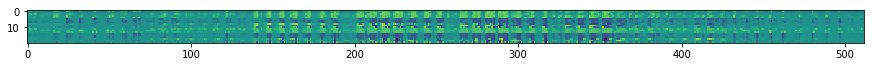

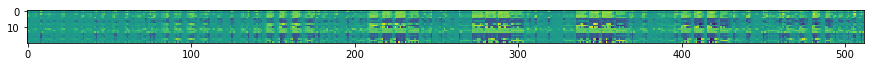

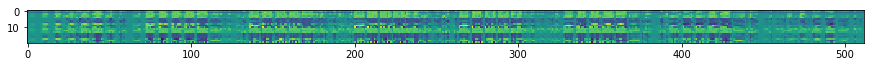

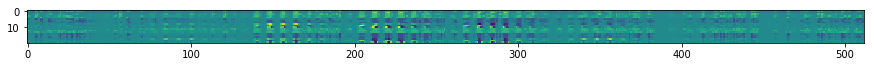

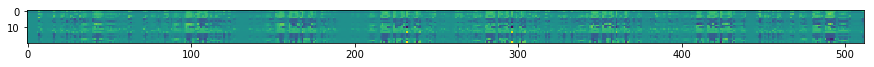

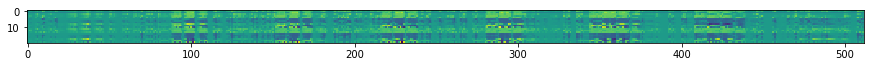

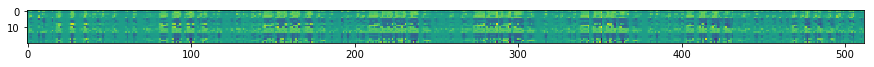

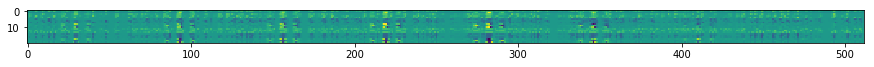

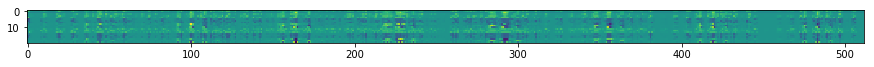

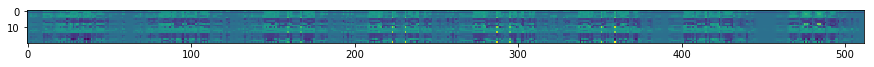

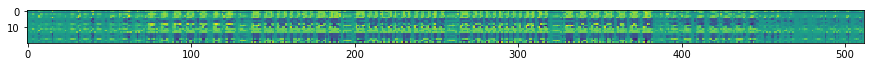

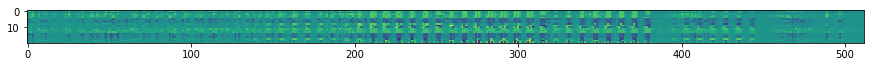

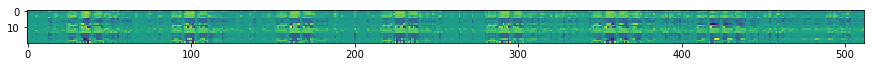

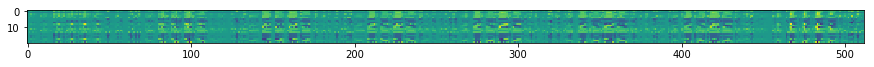

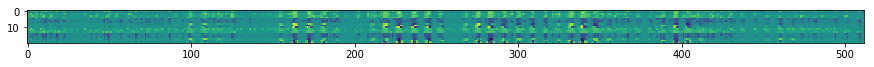

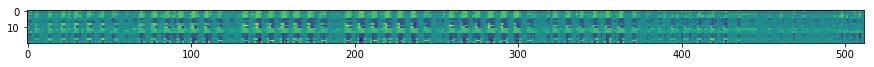

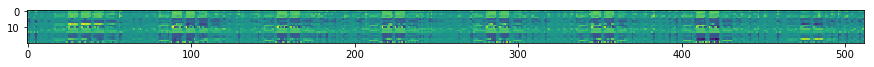

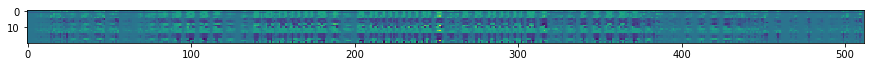

In [11]:
for f in feature_maps:
    plt.figure(figsize=(15,15))
    plt.imshow(f, interpolation=None)
    plt.show()